# DSMCER Notebook 9 - Feature Engineering 2

1. More feature extraction
   1. _Poll_: List some possible features
   2. Molecules
2. Feature selection
   1. By filtering
   2. Forward and reverse selection
   3. PCA
3. Note on end-to-end selection

In [25]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.ensemble

import codecarbon
import xgboost

# ! NEW
import rdkit.Chem
import rdkit.Chem.Descriptors
import rdkit.Chem.rdMolDescriptors
import rdkit.ML.Descriptors.MoleculeDescriptors

In [ ]:
rdkit.Chem.rdMolDescriptors

***
***

## 1. More feature extraction

<font size=5><center> In our first SML lecture, we encoded nominal variables (the identity of DES agents) with OneHotEncoding:

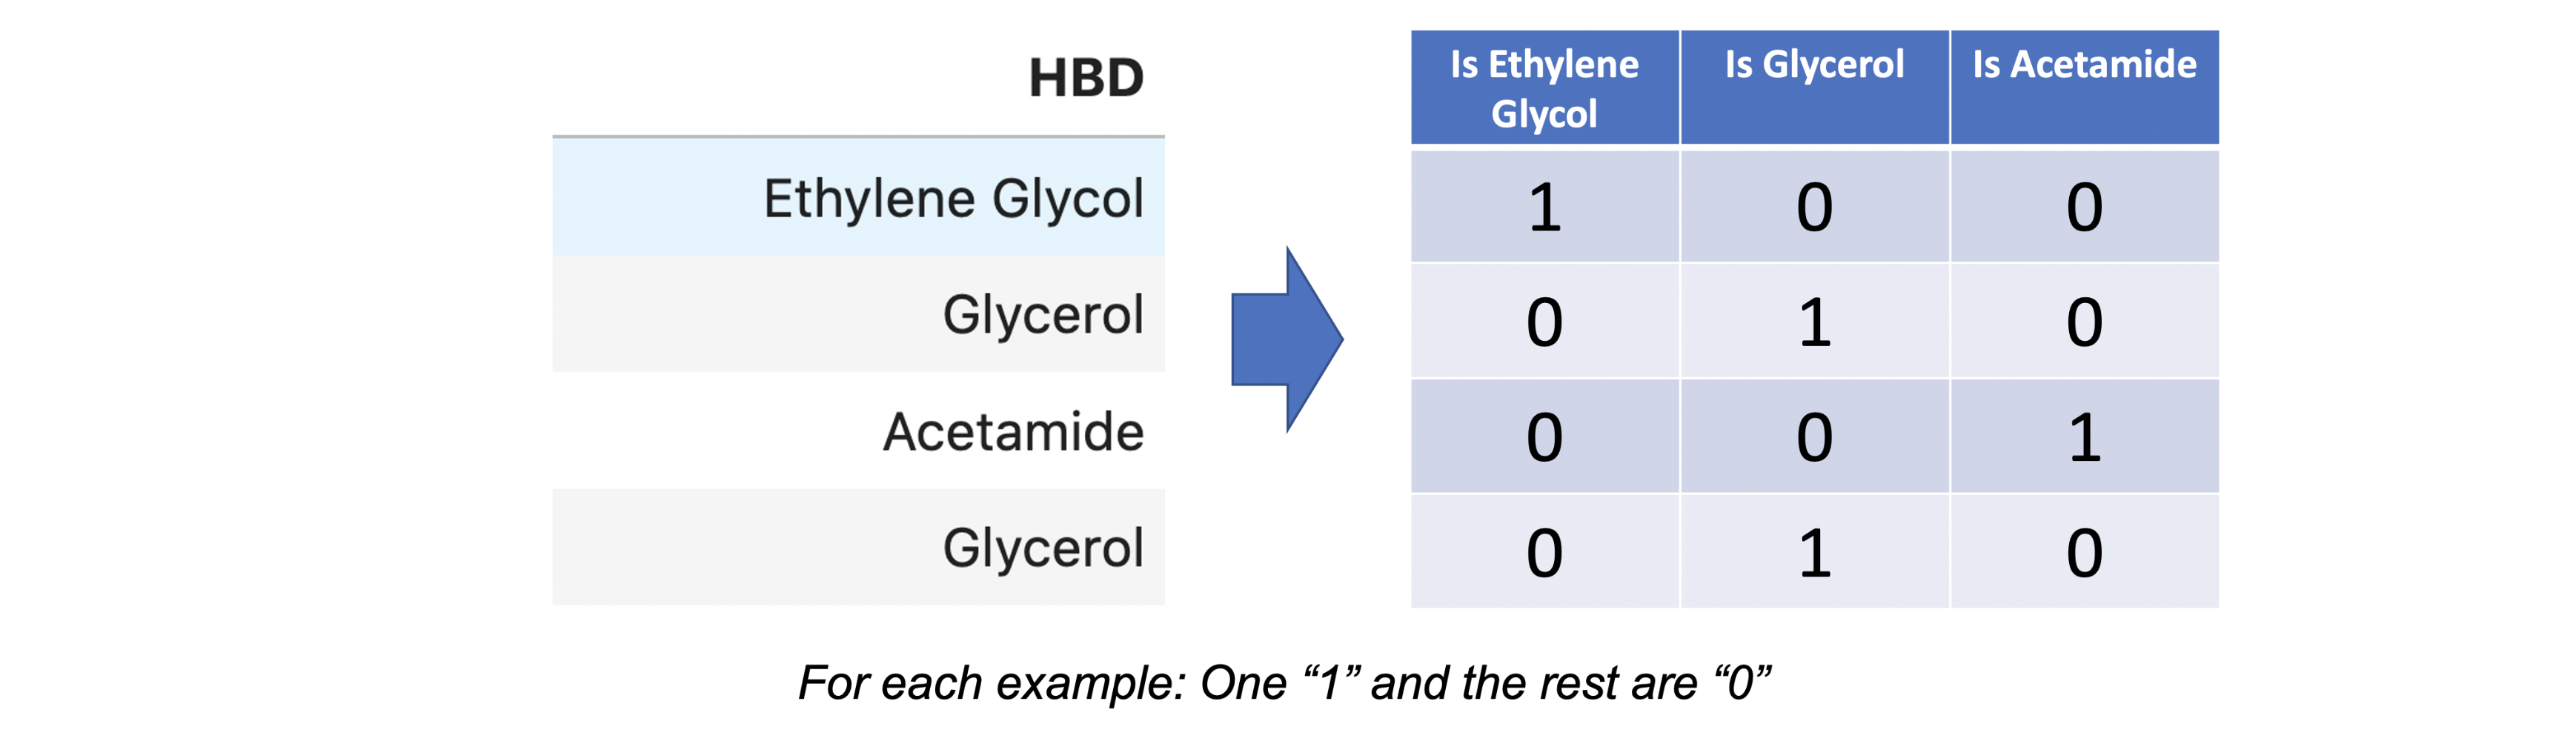

<font size=5><center> This was a rudimentary form of *feature selection*, but it is limited to the case when future examples __never have new nominal values__. 

***

### A. _Poll_: List some possible features

<font size=4> To create an SML model that would function __for new molecules not seen in training__ we had to engineer some new features that we expected to effect the DES mixture like molar mass and melting point. 
    
<font size=4><center> __Consider the following problem statement__: Create a predictor of human longevity.</center>
    
<font size=4>It would not be useful to OneHotEncode people, because the people we want to make predictions for are different from the ones we can take data for. __List some features we could extract from a person to try to predict their lifespan__?

***

### B. Molecules

<font size=5><center> __What features we can extract are task dependant__, but there are common things we can do for molecules and materials. 

<font size=4>__Hopefully working through this example of extracting features for molecules will give you a bigger picture of feature extraction for other examples__. It may also be that you end up working with molecules. Enter the `rdkit` molecules object:

In [2]:
help(rdkit.Chem.Mol)

Help on class Mol in module rdkit.Chem.rdchem:

class Mol(Boost.Python.instance)
 |  The Molecule class.
 |  
 |  In addition to the expected Atoms and Bonds, molecules contain:
 |    - a collection of Atom and Bond bookmarks indexed with integers
 |        that can be used to flag and retrieve particular Atoms or Bonds
 |        using the {get|set}{Atom|Bond}Bookmark() methods.
 |  
 |    - a set of string-valued properties. These can have arbitrary string
 |        labels and can be set and retrieved using the {set|get}Prop() methods
 |        Molecular properties can be tagged as being *computed*, in which case
 |          they will be automatically cleared under certain circumstances (when the
 |          molecule itself is modified, for example).
 |        Molecules also have the concept of *private* properties, which are tagged
 |          by beginning the property name with an underscore (_).
 |  
 |  Method resolution order:
 |      Mol
 |      Boost.Python.instance
 |      bui

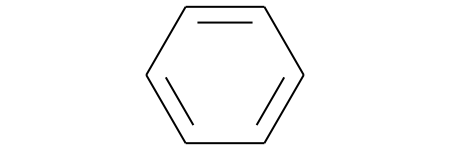

In [3]:
benzene = rdkit.Chem.MolFromSmiles('c1ccccc1')
benzene

<font size=4>*A note on "SMILES" stings. [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) (__S__ implified __M__ olecular-__I__ nput __L__ ine-__E__ ntry __S__ tring) defines the atoms in a molecule and the bonding pattern of the atoms. Please see the resource for more information.*

<font size=4>`rdkit` allows us to quickly extract many features from the SMILES string:

In [8]:
my_features = ['MolLogP', 'NumAromaticRings', 'MolWt']

In [9]:
calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(my_features)

In [10]:
calculator.CalcDescriptors(benzene)

(1.6866, 1, 78.11399999999999)

<font size=4>Instead of chosing specific descriptors, we might just extract them all... that is where the next section comes in ;)

In [11]:
all_descriptors = [name for name, _ in rdkit.Chem.Descriptors._descList]
print(all_descriptors)

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

In [12]:
calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(all_descriptors)

In [15]:
features = calculator.CalcDescriptors(benzene)
print(features)

(2.0, 2.0, 2.0, 2.0, 0.4426283718993647, 78.11399999999999, 72.06599999999999, 78.046950192, 30, 0, -0.062268570782092456, -0.062268570782092456, 0.062268570782092456, 0.062268570782092456, 0.3333333333333333, 0.5, 0.6666666666666666, 13.646993161855445, 10.379006838144555, 1.5737245910733604, -1.6942617326375449, 1.794093161855452, -1.4738931618554547, 4.985993161855456, 1.718006838144549, 3.000000000000001, 71.96100505779535, 4.242640687119286, 3.464101615137755, 3.464101615137755, 3.0, 2.0000000000000004, 2.0000000000000004, 1.1547005383792521, 1.1547005383792521, 0.6666666666666671, 0.6666666666666671, 0.38490017945975075, 0.38490017945975075, -0.78, 34.3994618804395, 3.4115708812260532, 1.6057694396735218, 0.5823992601400448, 37.43140311949697, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.39820241076966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.39820241076966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.39820241076966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

<font size=4>Each one of these __describes something physically interpretable about the molecule__. This type of feature is called a *descriptor*. 
    
<font size=4>Let's extract some descriptors for the whole dataset

In [24]:
rdkit.ML.Descriptors.Properties.GetAvailableProperties()

AttributeError: module 'rdkit.ML.Descriptors' has no attribute 'Properties'

***

In [17]:
# load the data by downloading it
df = pd.read_csv('http://faculty.washington.edu/dacb/HCEPDB_moldata.zip').sample(5000, random_state=200)

In [18]:
# get the y data
y = df['e_gap_alpha'].values

In [22]:
# compute features for the X data
X = []
for smiles in df['SMILES_str']:
    mol = rdkit.Chem.MolFromSmiles(smiles)
    descriptors = calculator.CalcDescriptors(mol)
    X.append(descriptors)
X = np.vstack(X)

[11:15:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 17 18 19 20 21 22
Traceback (most recent call last):
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/Chem/EState/EState.py", line 76, in MaxEStateIndex
    return max(EStateIndices(mol, force))
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/Chem/EState/EState.py", line 46, in EStateIndices
    nAtoms = mol.GetNumAtoms()
AttributeError: 'NoneType' object has no attribute 'GetNumAtoms'
Traceback (most recent call last):
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/pyt